### Imports

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional  as F
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

### What is a Deep Learning Model?

A deep learning model is a type of artificial neural network designed with multiple layers between input and output, enabling it to automatically learn and extract features from data without explicit programming. The "deep" in deep learning refers to the depth of the network, signifying the numerous interconnected layers of nodes. Each layer processes information at different levels of abstraction, with weights adjusted during training to improve the model's ability to make predictions or classifications. 

To Classify the images in the MNIST dataset, im going to use a Multilayer Perceptron or MLP model. The MLP (Ivakhnenko; Lapa; Lapa, 1967), is a type of Feed-
Forward Artificial Neural Network (FF-ANN) that consists of multiple layers of perceptrons and usually one type of activation function (which creates the non-linearities to the model). Assuming an initial model architecture with a single hidden layer with n neurons, the MLP is depicted as:

$$
f(x) = \alpha_0 + \sum_{j=1}^n\alpha_j \phi\left(\sum_{i=1}^k \beta_{ij}x_{t-1} + \beta_{0j}\right)
$$

Where:
 - $k$ is the number of predictors or input nodes, 
 - $n$ is the number of neurons on the hidden layer, 
 - $\phi$ is the activation function, 
 - $\alpha_j$ and $\beta_{ij}$, are the vector weights from the hidden layer to the output layer, and from the input layer to hidden layer, respectively. 
 - $\alpha_0$ and $\beta_0$ are the biases.
 
Generally, MLPs encompass neural network architectures that incorporate two or more hidden layers, which introduces additional complexities with nested non-linearities for each additional layer. 

For a comprehensive introduction to Neural Networks i strongly recommend: https://cs231n.github.io/ for the Stanford CS Class

#### Data Load - MNIST

The MNIST (Modified National Institute of Standards and Technology) database is a widely used collection of handwritten digit images, commonly employed as a benchmark in the field of machine learning and computer vision. Consisting of a training set of 60,000 examples and a test set of 10,000 examples, each image in MNIST is a grayscale 28x28 pixel representation of a handwritten digit (0 through 9)

Source: www.di.ens.fr/~lelarge/MNIST.tar.gz

In [233]:
image, label = torch.load(r'C:\Users\vnaza\OneDrive\Documentos\Projetos\DeepLearning\MNIST - Pytorch\Data\MNIST\processed\training.pt')

In [234]:
print(f'Image/X Shape = {image.shape} - its the tensor representation of a image')
print(f'Label/y Shape = {label.shape} - its the representataton of the image label')
print(f'Label/y sample = {label[0:5]}')

Image/X Shape = torch.Size([60000, 28, 28]) - its the tensor representation of a image
Label/y Shape = torch.Size([60000]) - its the representataton of the image label
Label/y sample = tensor([5, 0, 4, 1, 9])


Also, its possible to check out the images:

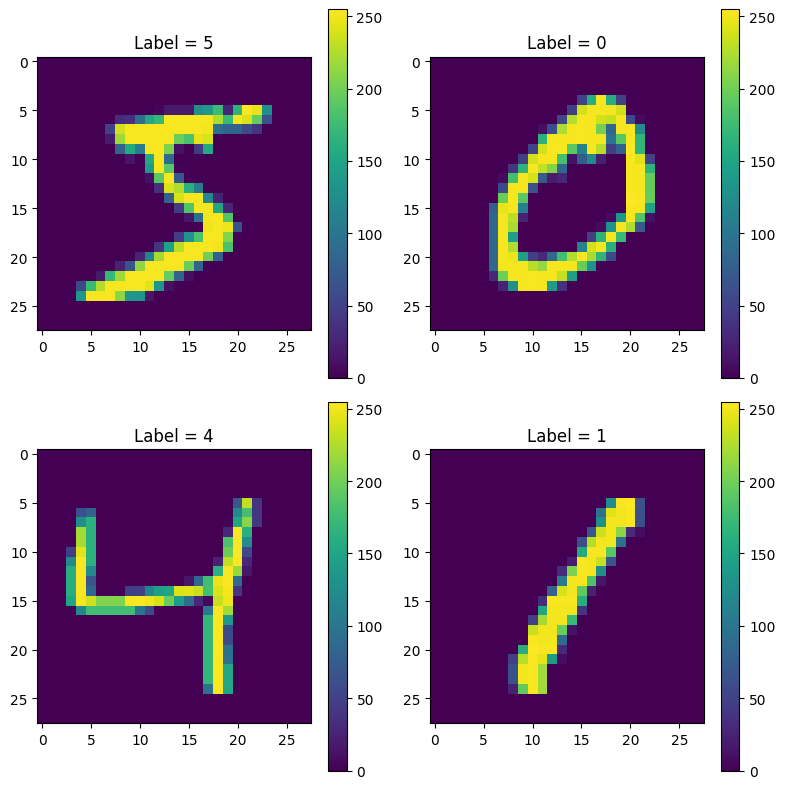

In [235]:
fig, axs = plt.subplots(2,2,figsize=(8,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(image[i])
    plt.title(f'Label = {label[i]}')
    plt.colorbar() # With this method the graph displays the color values for each pixel in the 28x28 image
    
plt.tight_layout()

### Processing the data labels - One Hot Encoder

One-hot encoding is a technique used in machine learning and data preprocessing, particularly in the context of handling categorical data. Categorical data represents variables that can take on a limited, and usually fixed, number of values or categories. One-hot encoding is used to represent categorical variables as binary vectors, which can be particularly useful for machine learning algorithms. 

Below is an example of how one hot enconding woks:

In [236]:
y_example = torch.tensor([0,1,2,3,4,5,6]) # Creates a tensor
y_example_one_hot = F.one_hot(y_example) # Creates a one hot encoded representation for this tensor

Therefore:

In [237]:
print('Actual labels: \n', y_example)
print('One Hot Encoded labels: \n', y_example_one_hot)

Actual labels: 
 tensor([0, 1, 2, 3, 4, 5, 6])
One Hot Encoded labels: 
 tensor([[1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1]])


Below im doing this to the full training dataset:

In [238]:
label_onehot = F.one_hot(label, num_classes=10)

In [239]:
print('Actual labels: \n', label)
print('One Hot Encoded labels: \n', label_onehot
)

Actual labels: 
 tensor([5, 0, 4,  ..., 5, 6, 8])
One Hot Encoded labels: 
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0]])


### What is a Pytorch Dataset?

The torch Dataset class in PyTorch acts as a blueprint for crafting custom datasets, that serve to not only read the data but to also make the transformation that it requires in a simple and compact way. In this example, i create the `MNISTImageDataset` class. that reads the filepath of the data, puts the y vector in one hot encoded and has the option to "normalize" the pixeL values from the image (this is not mandatory, but its good practice to make it in between 0 and 1). The Class also accepts the `num_classes` argument, that is used to indicate how many classes or output features we have. In this case 10, because the images vary from 1 to 10. I also added a show_image method, just so i can see what image is based on its index.

In [252]:
class MNISTImageDataset(Dataset):
    def __init__(self, filepath, num_classes, normalize=True):
        self.image, self.label = torch.load(filepath)
        if normalize:
            self.image = self.image/255
        self.hot_label = F.one_hot(self.label, num_classes=num_classes).to(float)
        
    def __len__(self):
        return len(self.hot_label)

    def __getitem__(self, idx):
        return self.image[idx], self.hot_label[idx]
    
    def show_image(self,idx):
        plt.imshow(self.image[idx], cmap=plt.get_cmap('gray'))
        plt.title(f'Target Label = {self.label[idx]}')
        plt.colorbar()

In [253]:
train_set = MNISTImageDataset(r'C:\Users\vnaza\OneDrive\Documentos\Projetos\DeepLearning\MNIST - Pytorch\Data\MNIST\processed\training.pt', num_classes=10)
test_set = MNISTImageDataset(r'C:\Users\vnaza\OneDrive\Documentos\Projetos\DeepLearning\MNIST - Pytorch\Data\MNIST\processed\test.pt', num_classes=10)

### What is a Pytorch Dataloader?

The `DataLoader` in PyTorch is a utility that helps efficiently load and iterate over datasets during the training or evaluation of the model. It works in conjunction with the `Dataset` class. The `DataLoader` takes a dataset instance and provides functionalities such as batching, shuffling, and parallel data loading. By specifying parameters like `batch_size` (number of samples per batch), `shuffle` (whether to shuffle the data at the beginning of each epoch), and `num_workers` (the number of parallel processes to load data), the DataLoader simplifies the process of feeding data to a model in a way that is compatible with parallel processing on multi-core systems. This is crucial for enhancing training efficiency and ensuring that the model receives diverse and randomized samples for better learning. In the example i create one dataloader for training and one for testing

In [254]:
train_loader = DataLoader(train_set, batch_size=5)
test_loader = DataLoader(test_set, batch_size=5, shuffle=True)

### Image Issues

Image tensors often present a problem that needs to be adressed before being fed to the model. In the way that they are the shape is 28x28, that the model does no accept. So before we plug this data in the model itself it needs to be flatten, which means that for each image the model wil receive one vector so a $28^2 = 784$ length vector. This can be done by using `view()` method or a more elegant approch using the `nn.Flatten()`

In [255]:
image.view(-1, 28**2).shape #using view

torch.Size([5, 784])

In [256]:
m = nn.Flatten() # Using Flatten()
for image, label in train_loader:
    print(m(image).shape)
    print(label.shape) 
    break

torch.Size([5, 784])
torch.Size([5, 10])


### Network Model

The network architecture consists of a sequence of layers defined using PyTorch's Sequential (`torch.nn.Sequential(`) module. The input dimensionality is specified during the instantiation of the network, and the architecture includes three hidden layers, each with 64 neurons and Rectified Linear Unit (ReLU) activation functions (the most common activation function). The final layer has 10 neurons, that is the number of classes in the label vector. `input_dim` argument is used to tell the model the length of the flattened image vector ($784$).

The forward method in the class is responsible for performing the forward pass through the defined layers. It takes an input tensor (image) and passes it through the sequential layers, producing an output tensor. As explained ealier, the `nn.Flatten()` layer is used to convert the input tensor into a one-dimensional array before feeding it through the fully connected layers. The ReLU activation functions introduce non-linearity to the network, allowing it to learn complex mappings from input to output.

In [257]:
class FeedForwardNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.network = torch.nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )
    
    def forward(self, image: torch.Tensor):
        return self.network(image)

The `train()` function takes three parameters: a Dataloader (`DataLoader`), a neural network (`Net`), and an optional number of training epochs (`n_epochs`, with a default value of 20). Inside the function, it sets up the optimization process by using stochastic gradient descent (`SGD`) as the optimizer with a learning rate of 0.001 and the cross-entropy loss function (`nn.CrossEntropyLoss`). It initializes an empty dictionary called `train_losses` to store the training losses.

The training loop runs for the specified number of epochs. Within each epoch, the function iterates over the batches of data provided by the data loader. For each batch, it performs a forward pass through the neural network to obtain predictions, calculates the loss between the predictions and the actual labels, and then performs a backward pass to compute gradients and update the network's parameters using the optimizer. The average loss for the current epoch is printed, and the training loss is appended to the `train_losses` dictionary. Finally, the function returns the training losses in the form of a Pandas DataFrame.

It's worth noting that this code assumes the neural network (`Net`) is a PyTorch model, and the data loader (`DataLoader`) provides batches of image-label pairs for training. Additionally, it utilizes the NumPy library to manage losses during training and the PyTorch framework for defining and optimizing the neural network.

In [258]:
def train(DataLoader, Net, n_epochs=20):
    
    # Optimization
    optimizer = SGD(Net.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    # Instantiate Loss Series
    train_losses = {}
    train_losses['Loss'] = []
    
    Net.train()
    
    for epoch in range(1, n_epochs+1):
        
        losses = np.array([])
        
        for batch, (image, label) in enumerate(DataLoader):

            # =================== Forward Pass =====================
            prediction = Net(image)
            loss = loss_fn(prediction,label) 
            losses = np.append(losses, loss.item())
            
            # =================== Backward Pass ====================
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step() 

        # =================== Log Losses ========================
        print(f'Epoch [{epoch}/{n_epochs}], Loss:{np.mean(losses)}')
        train_losses['Loss'].append(np.mean(losses))
        
    return pd.DataFrame(train_losses)

Similar to the training function, the `predict()` function takes two parameters: a Dataloader (`DataLoader`) and a neural network (`Net`). Inside the function, it initializes a dictionary called `df_test` to store information related to the predictions. This dictionary has three keys: 'Label' for the true labels, 'Prediction' for the predicted labels, and 'Batch_Accuracy' for the accuracy of each batch.

Within the prediction loop, the function iterates over the batches of data provided by the DataLoader. For each batch, it performs a forward pass through the neural network to obtain predictions. To assess model accuracy, it converts the predictions and true labels from PyTorch tensors to NumPy arrays and then uses the `accuracy_score` function to calculate the accuracy for the current batch. The true labels, predicted labels, and batch accuracy are appended to the `df_test` dictionary.

Finally, the function returns the collected information in the form of a Pandas DataFrame, where each row corresponds to a batch, and columns include the true labels, predicted labels, and batch accuracy. This code specifically assumes that the neural network (`Net`) returns raw predictions and the labels are one-hot encoded.

In [259]:
def predict(DataLoader, Net):
    
    df_test = {}
    df_test['Label'] = []
    df_test['Prediction'] = []
    df_test['Batch_Accuracy'] = []
    
    with torch.no_grad():
        for batch, (image, label) in enumerate(DataLoader):

            # =================== Forward Pass =====================
            prediction = Net(image)
                   
            # =================== Track Model Accuracy =====================
            prediction = torch.argmax(prediction, dim=1).numpy()
            label =  torch.argmax(label, dim=1).numpy()

            batch_accuracy = accuracy_score(label,prediction)
            df_test['Label'].append(label)
            df_test['Prediction'].append(prediction)
            df_test['Batch_Accuracy'].append(batch_accuracy)
      
    return pd.DataFrame(df_test)

Putting the functions to work (takes a few minutes):

In [260]:
network = FeedForwardNet(784)
df_losses = train(train_loader, network)

Epoch [1/20], Loss:2.0819969629024464
Epoch [2/20], Loss:0.7029358456186501
Epoch [3/20], Loss:0.4192453318807376
Epoch [4/20], Loss:0.3515455493024462
Epoch [5/20], Loss:0.31260898227194106
Epoch [6/20], Loss:0.2822349006177542
Epoch [7/20], Loss:0.2560486790338909
Epoch [8/20], Loss:0.23226001165192467
Epoch [9/20], Loss:0.21060839090443012
Epoch [10/20], Loss:0.19134316990564806
Epoch [11/20], Loss:0.1746963172482106
Epoch [12/20], Loss:0.1605381541450295
Epoch [13/20], Loss:0.14846646683827258
Epoch [14/20], Loss:0.13813572544881686
Epoch [15/20], Loss:0.1290743683907803
Epoch [16/20], Loss:0.12114154653661285
Epoch [17/20], Loss:0.11420393966138469
Epoch [18/20], Loss:0.1080518634914561
Epoch [19/20], Loss:0.10251343239690726
Epoch [20/20], Loss:0.09745318740017549


In [261]:
df_test = predict(test_loader, network)

Checking out the Mean accuracy:

In [262]:
df_test['Batch_Accuracy'].mean()*100

96.51

The average accuracy is indeed very good at $96.51\%$. Disclaimer: Since Deep Learning models relies on random initialization weights, results are not always guaranteed to be the exactly the same, but they tend to be close.

Below is the resulting dataframe defined earlier, showing each test batch and its accuracy. 


In [263]:
df_test

,Label,Prediction,Batch_Accuracy
0,"[3, 0, 8, 9, 4]","[3, 0, 8, 9, 4]",1.0
1,"[9, 1, 2, 5, 6]","[9, 1, 2, 5, 6]",1.0
2,"[1, 4, 8, 7, 3]","[1, 7, 2, 7, 3]",0.6
3,"[9, 4, 8, 1, 1]","[9, 4, 8, 1, 1]",1.0
4,"[6, 6, 7, 1, 1]","[6, 6, 7, 1, 8]",0.8
...,...,...,...
1995,"[7, 8, 1, 9, 2]","[7, 8, 1, 9, 2]",1.0
1996,"[8, 1, 8, 7, 6]","[8, 1, 8, 7, 6]",1.0
1997,"[4, 2, 7, 6, 2]","[4, 0, 7, 6, 2]",0.8
1998,"[1, 2, 7, 6, 1]","[1, 2, 7, 6, 1]",1.0


I then create a line plot of cross-entropy loss values (`df_losses`) over epochs. The title, x-axis label, and y-axis label are set accordingly. This plot is used to visualize the training progress and monitor how the cross-entropy loss changes during each epoch.

Text(0, 0.5, 'Cross Entropy Loss')

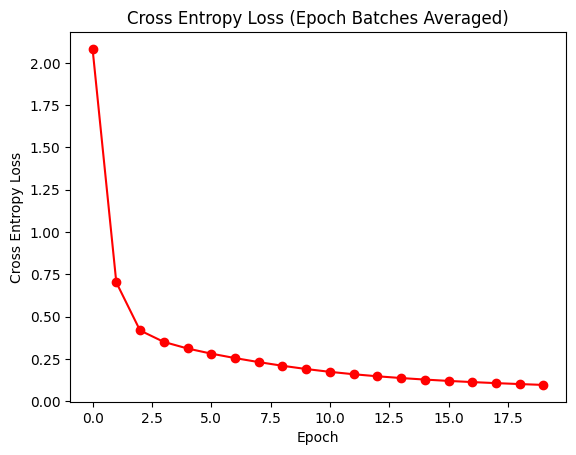

In [264]:
plt.plot(df_losses, 'o-', c='red')
plt.title('Cross Entropy Loss (Epoch Batches Averaged)')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')

Finally, we can **see** the results of our classification Net. And Make the prediction of just one Image 

Classification: [7]


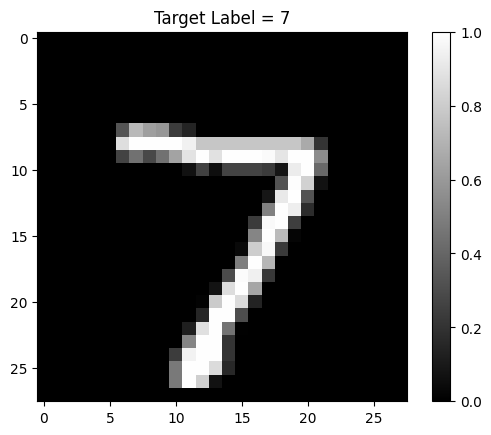

In [265]:
img_idx = 0

test_set.show_image(img_idx)
test_image = test_set[img_idx][0]
prediction = network(test_image.view(-1, 28**2)).argmax(axis=1) 
print('Classification:', prediction.numpy())

Or just see the first 40 predictions

In [274]:
test_images, test_labels  = test_set[:2000]
yhats = network(test_images).argmax(axis=1)

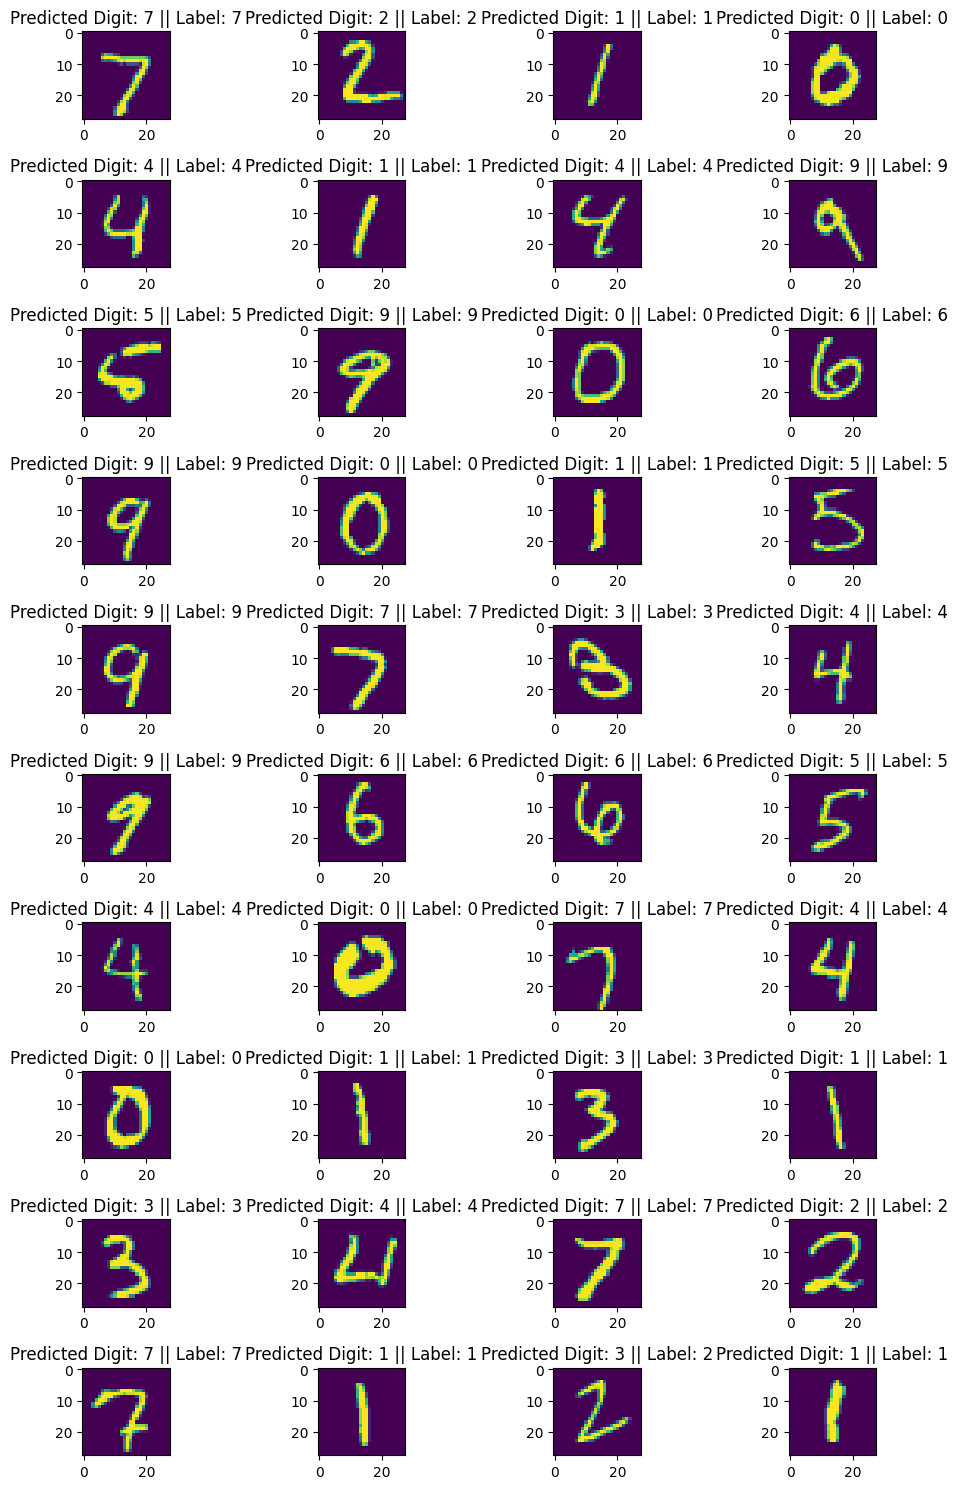

In [275]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(test_images[i])
    plt.title(f'Predicted Digit: {yhats[i]} || Label: {torch.argmax(test_labels[i], dim=0).numpy()}')
fig.tight_layout()
plt.show()